#ISONE winter OSW + Solar Analysis
This notebook is designed to re-perform the analysis of winter months, this time with varying GWs for solar and OSW, ultimately generating heatmaps that show the impact of varying GWs of both technologies.

**Part 1:**
The first things users need to do is fetch the appropriate data from the ISONE website.

In [1]:
#Step 1: read in the wind file from the ISONE website
import zipfile
import io
import requests
from glob import glob
import pandas as pd

url = "https://www.iso-ne.com/static-assets/documents/2023/05/2023_isone_ver_dataset_2000_2022_rev0.zip"
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
folder = "2023_isone_ver_dataset_2000_2022_rev0"
z.extractall(path=f"/content/{folder}")
files = glob(folder + "/*/*.csv")
index = files.index('2023_isone_ver_dataset_2000_2022_rev0/wind/2023_ISONE_Wind_ofsw_Aggregated_Power_Data_2000-2022_NetPwrTS.csv')

#Step 2: Read the CSV file into a dataframe for management/cleaning.
df = pd.read_csv(files[index])

#Step 3: Display the first few rows of the dataframe and confirm it is the right data.
df.head()

#Step 4: Create a new dataframe, "wind_data" with just the information we want.

#First, change the "Date" column in the original dataframe to "datetime" format.
#The datetime format allows us to manipulate the dates easily: https://docs.python.org/3/library/datetime.html
df['Date'] = pd.to_datetime(df['Date'])

#Next, create a new dataframe named "wind_data" to copy over just the columns we want.
wind_data = pd.DataFrame()

#Then, copy over the date column, which we have already put in datetime format!
wind_data['Date'] = df['Date'].copy()

#Finally, sum together the CP for every hour of the wind data, then add that as a column to our new dataframe as "Net CP for OSW Fleet".
wind_data['Net CP for OSW Fleet'] = sum([df['HE1'], df['HE2'], df['HE3'], df['HE4'], df['HE5'],
                                        df['HE6'], df['HE7'], df['HE8'], df['HE9'], df['HE10'],
                                        df['HE11'], df['HE12'], df['HE13'], df['HE14'], df['HE15'],
                                        df['HE16'], df['HE17'], df['HE18'], df['HE19'], df['HE20'],
                                        df['HE21'], df['HE22'], df['HE23'], df['HE24']])

#We can print the new dataframe to make sure we have what we want!
print(wind_data)

           Date  Net CP for OSW Fleet
0    2000-01-01               11.9738
1    2000-01-02               16.2638
2    2000-01-03               15.3354
3    2000-01-04               19.2895
4    2000-01-05               21.4297
...         ...                   ...
8396 2022-12-27               10.5740
8397 2022-12-28                9.0555
8398 2022-12-29               14.4821
8399 2022-12-30               14.4530
8400 2022-12-31               13.8022

[8401 rows x 2 columns]


**Part 2:** Read in and clean/format the load data!

In [2]:
#Step 1: read in the load file from the ISONE website
url = "https://www.iso-ne.com/static-assets/documents/2023/05/2023_isone_ver_dataset_2000_2022_rev0.zip"
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
folder = "2023_isone_ver_dataset_2000_2022_rev0"
z.extractall(path=f"/content/{folder}")
files = glob(folder + "/*/*.csv")
index = files.index('2023_isone_ver_dataset_2000_2022_rev0/load/ISONE_grossload_metdata_spliced_23yr_EPT.csv')

#Step 2: Read the CSV file into a dataframe for management/cleaning.
df = pd.read_csv(files[index])

#Step 3: Display the first few rows of the dataframe and confirm it is the right data.
df.head()

#Step 4: Combine the grid load based on dates, sum the load for the same day!
#We will use the groupby() function, and group the rows by day, summing over load column.
#We will save this into a series, which will have the date as the index, and the load for each cummulative day as the value.
gl = df.groupby('Date')['ISONE_grs_ld'].sum()

#Now, create a new dataframe for the grid_load, similar to the wind_data from above.
grid_load = pd.DataFrame()

#Then, copy over the indexes (dates) and values (cummulative load) to the new data frame.
grid_load['Date'] = gl.index.copy()
grid_load['Load'] = gl.values.copy()

#Ensure the date is in datetime format!
grid_load['Date'] = pd.to_datetime(grid_load['Date'])

#Print to make sure you have the data in the correct format!
print(grid_load)

           Date        Load
0    1999-12-31   73984.565
1    2000-01-01  354832.061
2    2000-01-02  349242.490
3    2000-01-03  350583.444
4    2000-01-04  345941.275
...         ...         ...
8398 2022-12-28  350730.536
8399 2022-12-29  328251.077
8400 2022-12-30  304037.998
8401 2022-12-31  288181.831
8402 2023-01-01   11102.659

[8403 rows x 2 columns]


**Part 3:** Read in and clean/format the solar resource data.

In [3]:
#Step 1: read in the solar file from the ISONE website
url = "https://www.iso-ne.com/static-assets/documents/2023/05/2023_isone_ver_dataset_2000_2022_rev0.zip"
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
folder = "2023_isone_ver_dataset_2000_2022_rev0"
z.extractall(path=f"/content/{folder}")
files = glob(folder + "/*/*.csv")
index = files.index('2023_isone_ver_dataset_2000_2022_rev0/solar/ISONE_solarcapacity_modeled_23yr_EPT.csv')
capacity = 12000

#Step 2: Read the CSV file into a dataframe for management/cleaning.
df = pd.read_csv(files[index], skiprows=1)

#Step 3: Display the first few rows of the dataframe and confirm it is the right data.
df.head()

#Step 4: Combine the solar supply capacity factors based on dates, sum the solar supply for the same day!
#We will use the groupby() function, and group the rows by day, summing over the power column.
#We will save this into a series, which will have the date as the index, and the supply for each cummulative day as the value.
pv = df.groupby('Date')['ISONE_pv_pwr'].sum()

#Now, create a new dataframe for the pv power, similar to the grid_load from above.
pv_power = pd.DataFrame()

#Then, copy over the indexes (dates) and values (solar CP sums) to the new data frame.
pv_power['Date'] = pv.index.copy()
pv_power['Solar Power CP'] = pv.values.copy()

#Ensure the date is in datetime format!
pv_power['Date'] = pd.to_datetime(pv_power['Date'])

#Print to make sure you have the data in the correct format!
print(pv_power)

           Date  Solar Power CP
0    1999-12-31        0.000000
1    2000-01-01        1.709263
2    2000-01-02        0.599718
3    2000-01-03        0.868599
4    2000-01-04        0.197456
...         ...             ...
8398 2022-12-28        1.398478
8399 2022-12-29        2.216775
8400 2022-12-30        2.175487
8401 2022-12-31        0.320828
8402 2023-01-01        0.000000

[8403 rows x 2 columns]


**Part 4:** Combine our 3 new dataframes so that they share a date column.

In [4]:
#Step 1: Use the merge function, provided by Pandas, to combine the three dataframes in two steps.
wind_solar_load_data = pd.merge(grid_load, wind_data, on = "Date", how = "left")
wind_solar_load_data = pd.merge(wind_solar_load_data, pv_power, on = "Date", how = "left")
#Print to ensure we have gotten it right!
print(wind_solar_load_data)

           Date        Load  Net CP for OSW Fleet  Solar Power CP
0    1999-12-31   73984.565                   NaN        0.000000
1    2000-01-01  354832.061               11.9738        1.709263
2    2000-01-02  349242.490               16.2638        0.599718
3    2000-01-03  350583.444               15.3354        0.868599
4    2000-01-04  345941.275               19.2895        0.197456
...         ...         ...                   ...             ...
8398 2022-12-28  350730.536                9.0555        1.398478
8399 2022-12-29  328251.077               14.4821        2.216775
8400 2022-12-30  304037.998               14.4530        2.175487
8401 2022-12-31  288181.831               13.8022        0.320828
8402 2023-01-01   11102.659                   NaN        0.000000

[8403 rows x 4 columns]


**Part 5:** Loop over all potential years to generate heatmaps of the data!

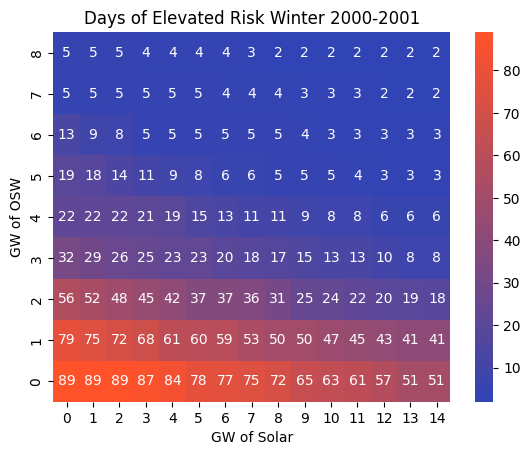

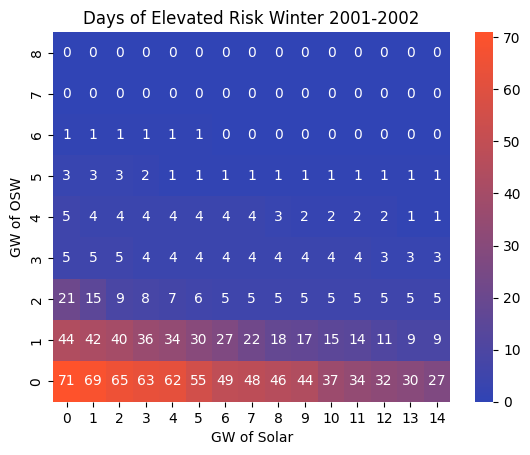

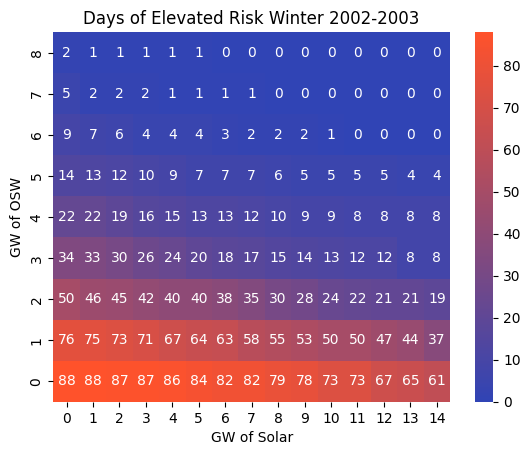

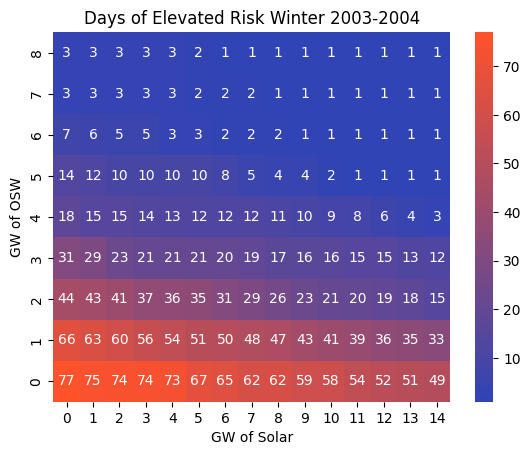

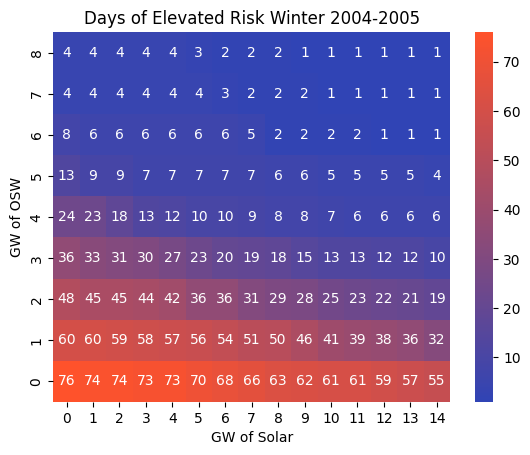

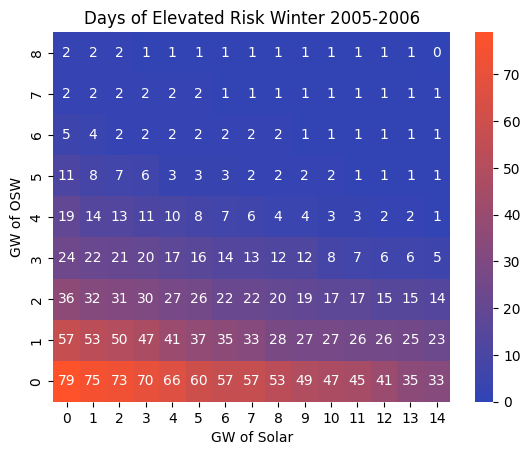

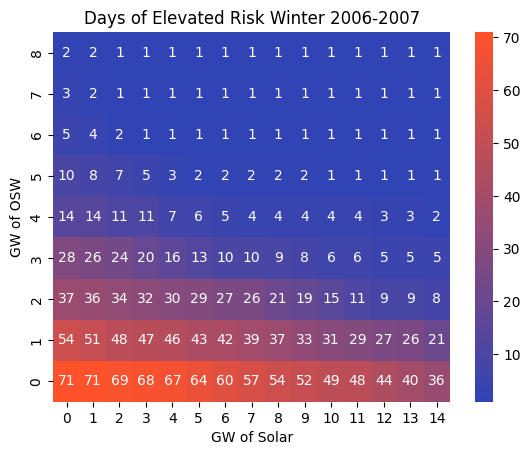

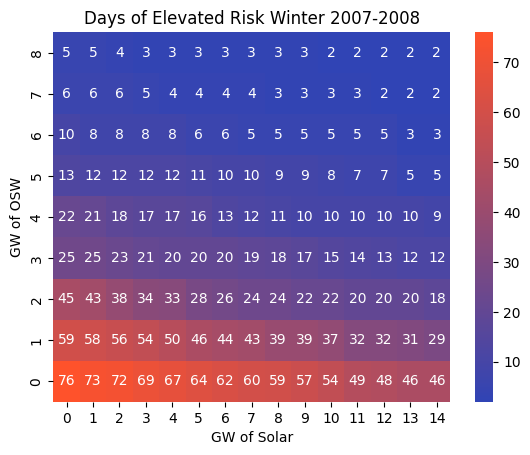

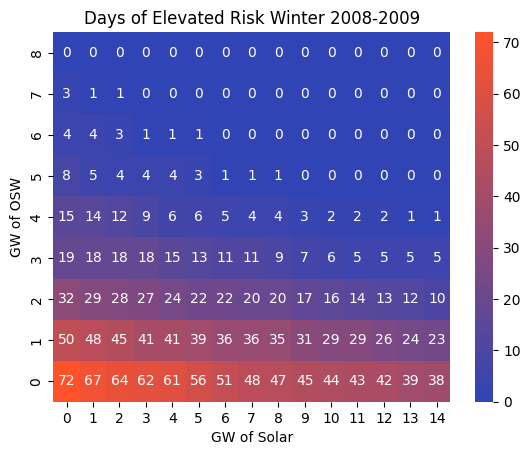

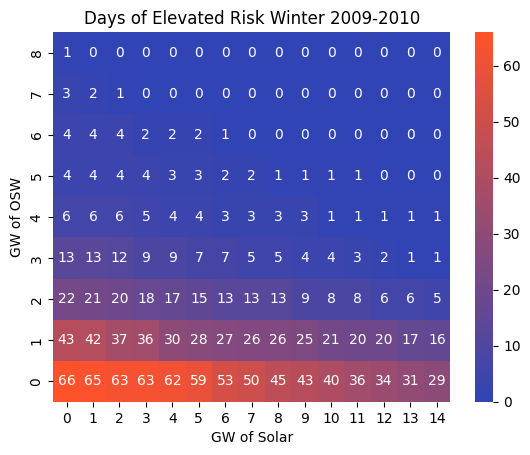

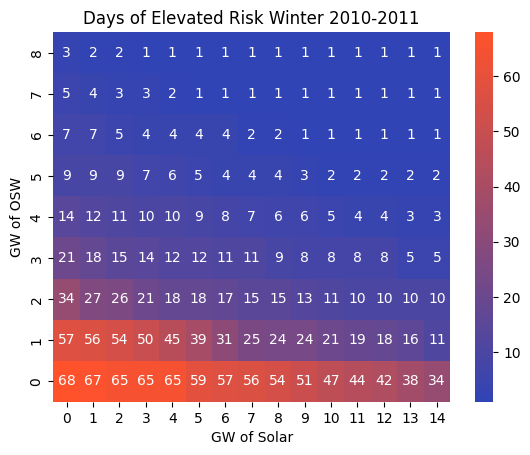

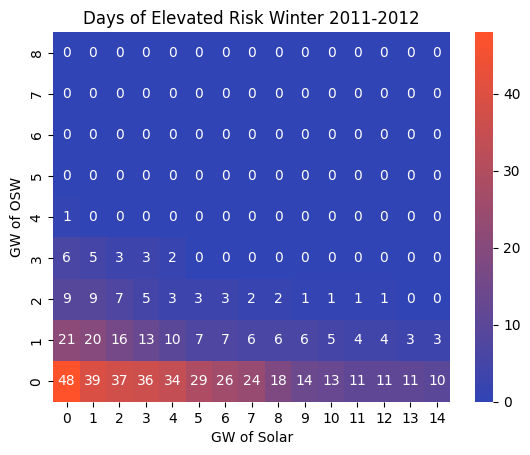

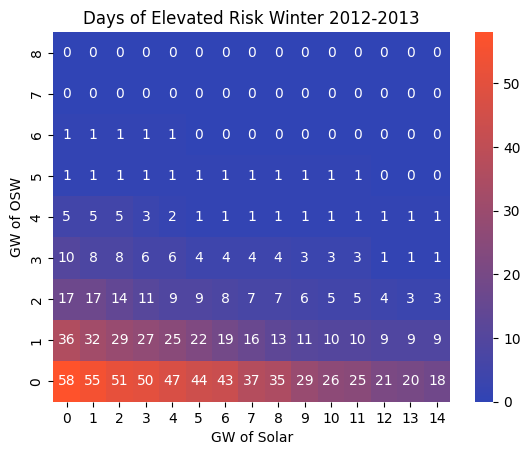

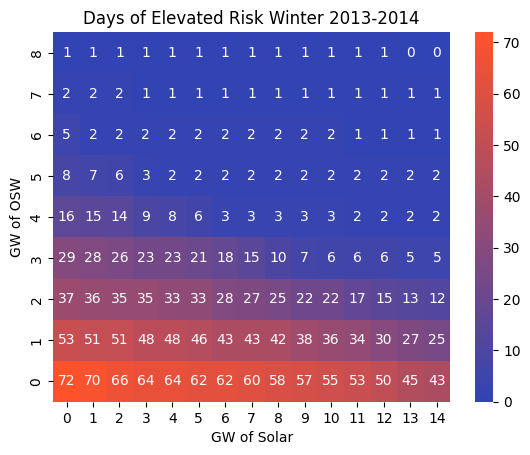

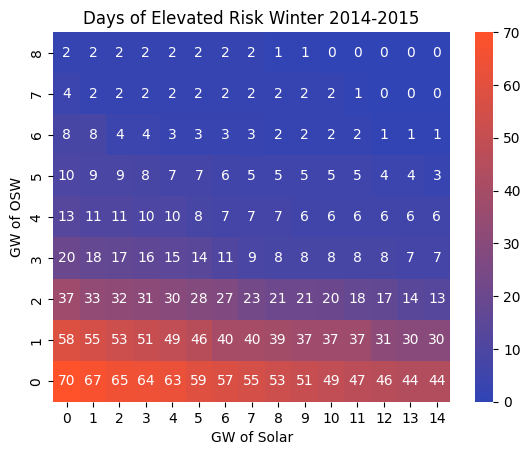

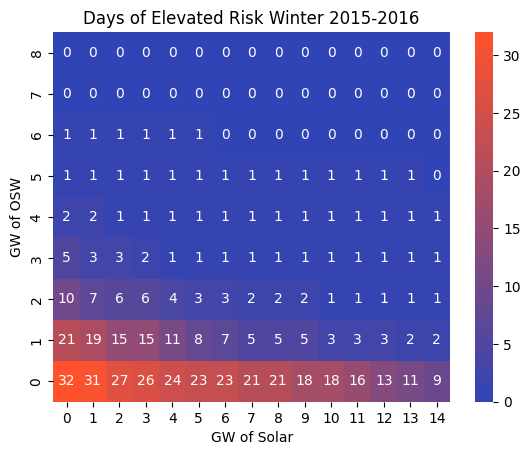

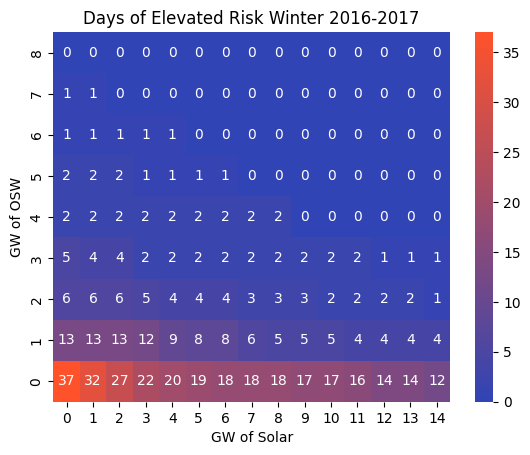

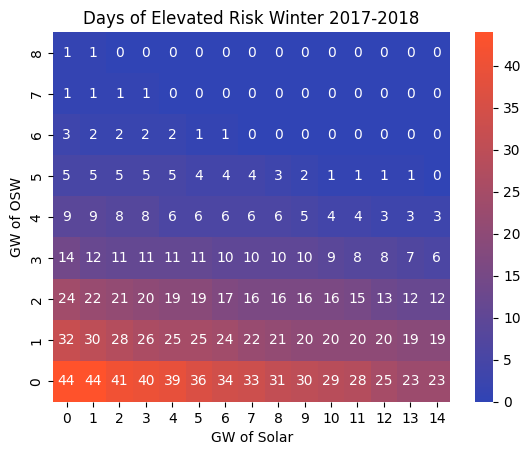

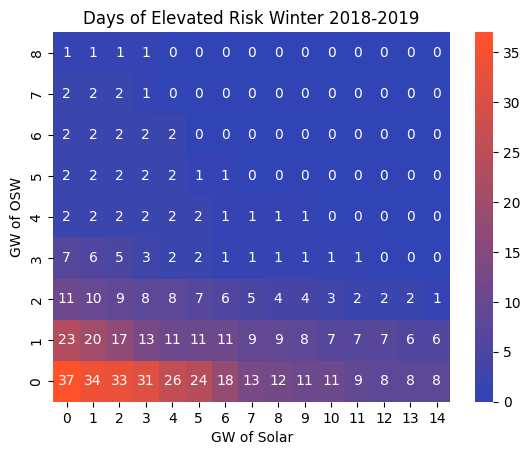

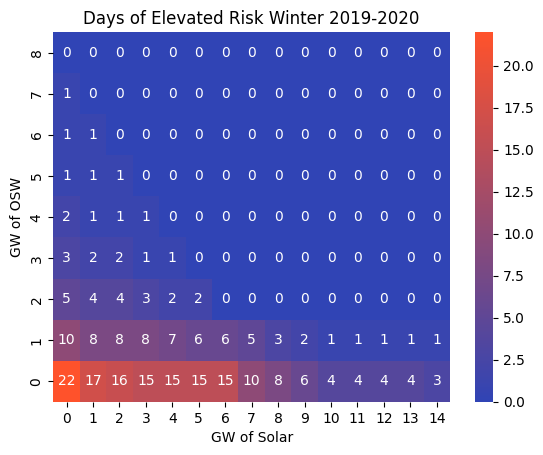

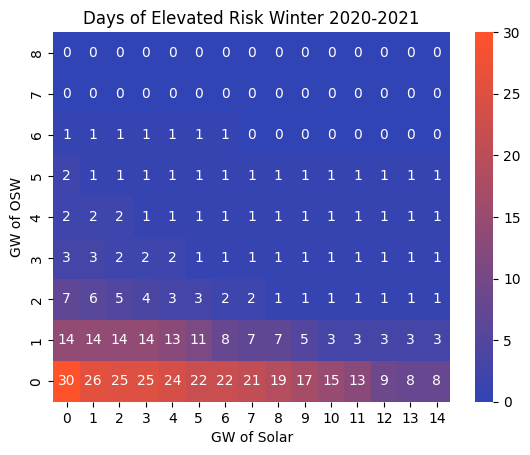

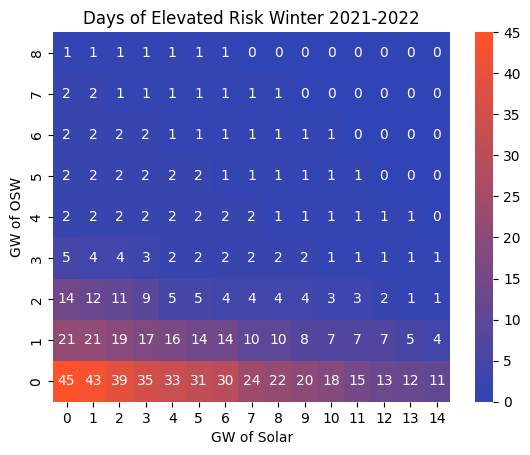

In [5]:
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import seaborn as sns


from matplotlib.colors import LinearSegmentedColormap
# Matching colors to UCS color selection!
custom_colors = [
    '#3044B5',
   '#FF522B',
]
custom_cmap = LinearSegmentedColormap.from_list("custom_gradient", custom_colors)
custom_cmap

#Step 1: Choose the year range
years_min=2000
years_max = 2022

i = years_min
#Step 2: Loop over all years in the dataset
while i < years_max:
  heat_map = []
  winter_year_one = i
  winter_year_two = i+1
  analysis_data = wind_solar_load_data.loc[((wind_solar_load_data['Date'].dt.year == winter_year_one) & (wind_solar_load_data['Date'].dt.month == 12)) | ((wind_solar_load_data['Date'].dt.year == winter_year_two) & ((wind_solar_load_data['Date'].dt.month == 1) | (wind_solar_load_data['Date'].dt.month == 2)))]
  x = 0
  #Step 3: Loop over potential OSW
  for x in range(9):
    #Loop over up to 8GW of OSW
    row = [] #Add each row to the heatmap
    y = 0
    #Step 4: Loop over potential solar
    for y in range(15):
        #y is the solar amount
        analysis_data['Load - '+str(x)+'MW OSW Fleet -' +str(y)+'MW Solar'] = analysis_data['Load'] - (analysis_data['Net CP for OSW Fleet'] * x*1000) - (analysis_data['Solar Power CP'] * y*1000)
        row.append(analysis_data[analysis_data['Load - '+str(x)+'MW OSW Fleet -' +str(y)+'MW Solar'] > 350000].shape[0]) #Add the number of days to the row for the heatmap
        y+=1
    heat_map.append(row) #Add the row to the heatmap
    x+=1

  #Plot the heatmap for each year
  # Create heatmap
  ax = sns.heatmap(heat_map, annot=True, cmap=custom_cmap)

  #Step 5: Plot and label the all axis
  # Invert y-axis
  ax.invert_yaxis()
  plt.title('Days of Elevated Risk Winter ' + str(winter_year_one) + '-' + str(winter_year_two))
  plt.xlabel('GW of Solar')
  plt.ylabel('GW of OSW')
  plt.show()
  i+=1